In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os


Mounted at /content/drive/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_train = pd.read_csv('/content/drive/MyDrive/DS_3/Constraint_Train.csv', index_col ='id')
df_train.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/DS_3/Constraint_Val.csv', index_col ='id')
df_test.head()

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [ ]:
def change(s):
  if s == 'real':
    return 1
  else:
    return 0

df_train['label'] = df_train['label'].apply(lambda x : change(x))

In [ ]:
def change_t(s):
  if s == 'real':
    return 1
  else:
    return 0

df_test['label'] = df_test['label'].apply(lambda x : change_t(x))

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text(0.5, 1.0, 'Data Distribution')

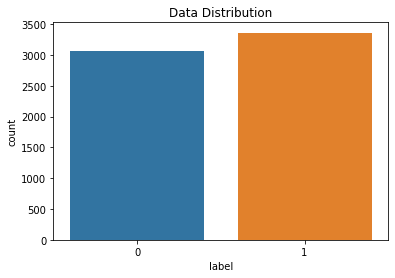

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = "label", data = df_train)
plt.title("Data Distribution")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data distribution seems quite workable.

Removing punctuation and unnecessary stop words.
Using stemmer to get similar results for different forms of the same words

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

stop_words =set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import PorterStemmer 

def preprocess(text):
  word_list = []
  tok = tokenizer.tokenize(text)
  for word in tok:
    if word not in stop_words:
      word_list.append(stemmer.stem(word))
  return " ".join(word_list)

In [ ]:
x_data = df_train["tweet"].apply(preprocess)
x_data.tail()

id
6416    A tiger test posit covid 19 pleas stay away pe...
6417    autopsi prove covid 19 blood clot pneumonia ou...
6418    _A post claim covid 19 vaccin alreadi develop ...
6419       aamir khan donat 250 Cr In PM relief care fund
6420    It 93 day sinc last case covid 19 acquir local...
Name: tweet, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, df_train['label'].values, test_size=0.10, random_state=42)

Using tf-idf to further minimize the weight of unnecessary words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

Important features:

In [ ]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
# sort ascending
df_idf.sort_values(by=['idf_weights']).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
http,1.663315
co,1.663987
covid,2.214818
19,2.386121
coronaviru,2.443076


In [ ]:
from sklearn.naive_bayes import BernoulliNB


In [ ]:
BernModel = BernoulliNB()
BernModel.fit(x_train_tfidf, y_train)
print(f"Training Score : {BernModel.score(x_train_tfidf, y_train)}")
print(f"Test Score : {BernModel.score(x_test_tfidf, y_test)}")

Training Score : 0.9518864659051575
Test Score : 0.9049844236760125


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
count_vect.fit(df_train['tweet'].values)

CountVectorizer()

In [ ]:
neg_class_prob_sorted = BernModel.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = BernModel.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['c2ytwp1ia1' 'canals' 'bound' 'encourages' '1760' 'olwalb7mxs'
 'impression' 'bloodletting' 'js8nbdq9ux' 'michiganders']
['encourages' 'bound' 'cancel_ca_cs_exams' 'bbcnews' 'canals' 'oh'
 'm1r4hcvejf' 'impression' 'necessities' '1760']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Mean Absolute Error: 0.09501557632398754
Accuracy: 0.9049844236760125
              precision    recall  f1-score   support

           0      0.862     0.950     0.904       302
           1      0.951     0.865     0.906       340

    accuracy                          0.905       642
   macro avg      0.907     0.908     0.905       642
weighted avg      0.909     0.905     0.905       642



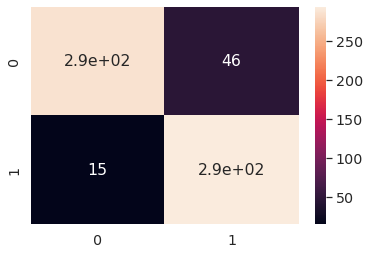

In [ ]:
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns

test_pred = BernModel.predict(x_test_tfidf)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show() 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components = 1)

In [ ]:
lda.fit(x_train_tfidf.todense(), y_train)
print(f"Training Score : {lda.score(x_train_tfidf.todense(), y_train)}")
print(f"Test Score : {lda.score(x_test_tfidf.todense(), y_test)}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Training Score : 1.0
Test Score : 0.6448598130841121


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Mean Absolute Error: 0.35514018691588783
Accuracy: 0.6448598130841121
              precision    recall  f1-score   support

           0      0.626     0.609     0.617       302
           1      0.661     0.676     0.669       340

    accuracy                          0.645       642
   macro avg      0.643     0.643     0.643       642
weighted avg      0.644     0.645     0.645       642



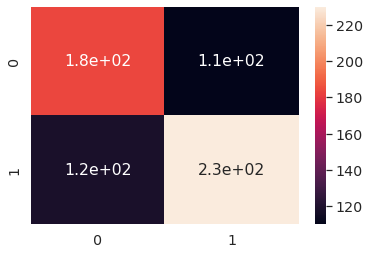

In [ ]:
test_pred = lda.predict(x_test_tfidf.todense())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show()